# League of Legends Data Analysis Tutorial

*Andrew Sarama, Elisabeth Jang*  
*May 16, 2022*  
*University of Maryland, College Park*  
*CMSC320*  

## Brief Introduction

League of Legends is a team-based 5v5 competitive Esport. Various data from previously played matches are saved to the LoL database. However, access to the database needs to be manually authenticated by the Riot Games Development Team. Luckily, authenticated API users have downloaded relevant data from thousands of games and uploaded the files for public access. This tutorial will be an effective introduction to analyzing LoL match data regardless of the user's authentication level.


### Important Game Mechanics

*Feel free to skip if you are already familiar with basic LoL gameplay*


#### Primary Game Objectives
The LoL map (also known as "The Rift") has 2 teams, *red* and *blue*. The goal of the game is to destroy the opposing team's *nexus*, located at the center of the opposing team's *base*. The nexus is protected by 4 layers of *towers*, which are non-regenerating defense turrets preventing players from simply walking into the enemy base. All 4 layers of towers must be penetrated before the nexus becomes attackable. 

#### Champions
Before the start of any match, all 10 players choose *champions* from a pool of ~150 playable characters. Champions can attack opposing champions and towers. Champions that die in combat will respawn in their base. Note that the only way to win is to destroy the opposing nexus--killing the enemy champions simply prevents them from protecting their towers and nexus. Each player gets to pick and ban exactly 1 champion.

#### Secondary Game Objectives
There are 3 secondary objectives on The Rift: killing the *Dragon*, killing the *Rift Herald*, and killing the *Baron*. All of these objectives spawn in set times and locations on The Rift, and the team that completes the objectives first gains bonuses that make destroying the opposing team's base easier.

## Data Analysis Opportunities

Using the data that is stored for LoL matches and some data analysis techniques, we can answer some of the following interesting questions (and many, many more):

1. Is the team that gets the "first blood" (first champion kill in the match) more likely to win? How good of a predictor is the first blood for the outcome of the game?
2. How does completing secondary objectives impact a team's chances of winning? Is killing the dragon a waste of a player's time, or is it a predictor of success?
3. What is the relationship between a champion's win rate, pick rate, and ban rate?
4. Is focusing more on secondary objectives than primary objectives a viable strategy?

## Data Collection and Parsing

Without a private Riot Games development key, finding LoL match data with very specific parameters is challenging. Luckily, if we want to analyze a large number of general matches, many such public datasets exist. This tutorial will use a free-to-download dataset containing ~50,000 matches played on the European Server. See [1] under *Resources* for a download link.

### Importing Necessary Libraries

The data will be stored in our Python code using the *pandas* library. The first step will be to import the library itself: (reference [2] is the link to the pandas documentation)

In [1]:
import pandas as pd

The data from this specific source has 4 files: games.csv (contains the game data) and 3 .json files for converting champion/spell IDs to their names. Let's first get the data from the games into a pandas DataFrame and observe what other data parsing needs to take place.

In [2]:
games = pd.read_csv("/home/jovyan/notebooks/Data/games.csv")

# there are a very large number of data columns, so let's look at the names of the first 11
display_cols = 11
i = 1
for col in games.columns:
    if i <= display_cols:
        display(col)
        i += 1

'gameId'

'creationTime'

'gameDuration'

'seasonId'

'winner'

'firstBlood'

'firstTower'

'firstInhibitor'

'firstBaron'

'firstDragon'

'firstRiftHerald'

These columns have very useful information about the events that took place in the match. From the description of the dataset at link [1], the 2 teams are given numerical identifiers 1 and 2. For all columns that show the 'first' (objective), they represent which team completed the objective first. However, not all objectives are necessary to win a game, so identifier 0 implies that neither team completed this objective.

Looking at the .csv file, there are a lot of columns that are unnecessary and needlessly cluttering the data. Here we will drop all of the columns that will not be used throughout this tutorial:

In [3]:
games.drop(columns=['gameId', 'creationTime', 'seasonId'], inplace = True)

### Using JSON to Clean Up

Many of the columns use numerical identifiers for champions and spells. Replacing those entries with the actual names of the champions will make interpreting the data significantly easier. We will use the *json* library to read the .JSON files into dictionaries for a quick conversion:

In [4]:
import json

champion_info = {}; # this will be a dictionary mapping champion ID to a set of parameters
with open("/home/jovyan/notebooks/Data/champion_info.json", "r") as read_file:
    champion_info = json.load(read_file)
    champion_info = champion_info['data'] # we don't need the game version and other extraneous data

From this, let's see what information we can find about champions with ID = 1:

In [5]:
display(champion_info['1'])

{'title': 'the Dark Child', 'id': 1, 'key': 'Annie', 'name': 'Annie'}

In [6]:
def champ_name_map(id): # this function will serve as a map 
  return champion_info[id]['name']

# the dataset gives numerical id's, while all json keys are strings
games['t1_champ1'] = games['t1_champ1id'].astype(str)
# the pandas "map" function applies a function to every element in the column. see reference [3]
games['t1_champ1'] = games['t1_champ1'].map(champ_name_map) # apply id string -> name mapping function
display(games[['t1_champ1id', 't1_champ1']].head(5))

,t1_champ1id,t1_champ1
0,8,Vladimir
1,119,Draven
2,18,Tristana
3,57,Maokai
4,19,Warwick


Converting any column of champion IDs in the dataframe into the champion name can make the data significantly more readable, especially to an outside audience. If we want to show which characters have the highest winrate, who will be able to tell which champion "championID = 1" is?

### Data Cleaning: Early Forfeited Games

In LoL, if a player disconnects within the first ~6 minutes of the game, the players in the game can vote to cancel the match. Games like this will prove to be outliers in a number of areas (low objective count, no tower destructions, no first bloods, etc). It makes a lot of sense to remove games like this.

A game cannot be forfeited or realistically lost before 10 minutes. Thus, any game that lasts less than 600 seconds is likely a game that was reset after a disconnect. Do any games like this exist?

In [7]:
len(games[games['gameDuration'] <= 600])

1204

So it appears that ~1200 of our games were canceled before the 10 minute mark. These games have no objectives taken or towers destroyed, so they won't be useful for analysis. Removing them is straightforward in pandas, as shown below:

In [8]:
games = games[games['gameDuration'] > 600]
games.reset_index(inplace = True) # this is necessary as some indexes will be left empty after dropping rows
len(games)

50286

## Data Analysis Example: First Blood

As an example exercise, we will determine whether the team that gets the *first blood* (reminder: this is the team that gets the first champion kill) is more likely to win the match. We will then do some hypothesis testing to check the statistical significance of the results.

First, let's figure out the win percentage of the team that gets the first blood. We know if the winning team gets the first blood whenever the 'winner' column is equal to the 'firstBlood' column.

In [9]:
# we are looking for the number of rows 
num_wins = len(games[games["winner"] == games["firstBlood"]])
num_games = len(games)

display((num_wins / num_games) * 100.0)

59.052221294197196

Interesting! According to the dataset, the team that gets the first blood has a 58.47% chance of winning the match. But how statistically significant is this result?

On average, two evenly matched teams should each have a winrate very close to 50%. It may be naive to assume that all teams in this dataset are "evenly matched", however, there is no good way to quantify the fairness of a match. For the rest of this analysis, let's assume that teams 1 and 2 are evenly matched, and thus have an equal chance of getting the first blood. There may be conflating variables such as champion selection/archetype, but let's ignore that for now.

### Hypothesis Testing

For this hypothesis test, let's be more statistically robust. Let's consider each team as an individual (meaning there are 2 data points per match). The independent variable is whether or not a team got the first blood. The dependent variable is whether or not the team won the match. Let's filter out some dataframes that represent these variables:

In [10]:
first_blood_win = 0
first_blood_loss = 0

for index, row in games.iterrows():
    if row['firstBlood'] == row['winner']:
        first_blood_win += 1
    else:
        first_blood_loss += 1
        
display([first_blood_win, first_blood_loss])

[29695, 20591]

Now, we have a categorical dependent and independent variable. We are hoping to show that the number of observations for the dependent categories is far enough away from the expected number of observations. If the first blood in a match had no correlation with the result, then we would expect the first blood teams to have an equal number of wins and losses (since the average winrate for a team would be 50%). 

This comparison of categorical variable frequencies is perfect for a chi-square test! The scipy library can quickly do the chi-square test for us:

In [11]:
import scipy.stats as stat

expected = (first_blood_win + first_blood_loss) / 2
display(stat.chisquare(f_obs = [first_blood_win, first_blood_loss], f_exp = [expected, expected]))

Power_divergenceResult(statistic=1648.2284532474248, pvalue=0.0)

Perhaps this test wasn't necessary, considering there is an almost 5,000 observation difference from the number we would expect. Thus, the p-value of this number of observations occurring naturally is so small, that it's rounded to 0.0. Without question, there is a correlation between the team that gets first blood and their chance of victory. This is likely because, in reality, teams are not always evenly matched--and the team with the better players is much more likely to both get the first blood *and* win. Unfortunately, the data does not have a metric for player skill, so let's take our analysis elsewhere.

Let's discuss which champions are correlated with an increased number of wins for their team *with statistical significance*. Let's set a maximum p-value of 0.05, meaning any chi-square test that has a p-value higher than 0.05 will not have a statistically significant advantage. In this case, the null hypothesis of the chi-square test is that for a game that contains character *x*, which team character *x* is on has no impact on the outcome of the match (win or loss).

Here, I will define a function that checks the champions of each team and counts the wins and losses for teams with a specific championID (numerical parameter):

In [12]:
# first, we will select the champion choices for each team from the games dataset
# passing in an array of column names returns a new dataframe with only those columns
team1_champs = games[['t1_champ1id', 't1_champ2id', 't1_champ3id', 't1_champ4id', 't1_champ5id']]
team2_champs = games[['t2_champ1id', 't2_champ2id', 't2_champ3id', 't2_champ4id', 't2_champ5id']]

# parameter championID denotes which champion's winrate we are currently performing the test on
def champion_win_pvalue(championID):
    win_with_champ = 0 # number of times champ is on the team and wins
    loss_with_champ = 0 # number of times champ is on the team and loses

    for index, row in team1_champs.iterrows():
        if championID in row.values: # row only contains champion IDs for team1, so other columns won't interfere
            if games.loc[index]['winner'] == 1:
                win_with_champ += 1
            else:
                loss_with_champ += 1

    for index, row in team2_champs.iterrows():
        if championID in row.values:
            if games.loc[index]['winner'] == 1:
                win_with_champ += 1
            else:
                loss_with_champ += 1
    
    if win_with_champ < loss_with_champ:
        return 1 # we are looking for who is statistically more likely to make their team *win*- we don't care if they make their team lose
                
    expected = (win_with_champ + loss_with_champ) / 2 # if the champ has no effect on the outcome, we would expect there to be equal win/loss
    test = stat.chisquare(f_obs = [win_with_champ, loss_with_champ], f_exp = [expected, expected])
    return test.pvalue

champion_win_pvalue(8) # championID 8 corresponds to Vladimir

0.299872658150015

Now we have a function that can take any individual champion, perform a chi-square test, and tell us if they have a statistically significant correlation with the result! Although we have a nice function, we have to manually check the winrate (we can get a statistically significant winrate of 50%) and that the p-value is low enough (p <= 0.05).

What if we want to see all of the champs that have this statistically significant correlation? To do this, let's make our code a bit more efficient:

In [13]:
champ_win_dict = {} # here we will store the wins/losses, so we don't have to iterate over the dataframe 150+ times!
winrate_threshold = 0.53 # let's arbitrarily say that the "best" champions must have a winrate of 53% with statistical significance
# feel free to play around with the above value to see which champions were truly impactful

# instantiate the dict with all the champions
for x in champion_info:
    champ_win_dict[x] = {}
    champ_win_dict[x]['w'] = 0 # count the number of wins
    champ_win_dict[x]['l'] = 0 # count the number of losses

for index, row in games.iterrows():
    if games.loc[index]['winner'] == 1:
        champ_win_dict[str(row['t1_champ1id'])]['w'] += 1
        champ_win_dict[str(row['t1_champ2id'])]['w'] += 1
        champ_win_dict[str(row['t1_champ3id'])]['w'] += 1
        champ_win_dict[str(row['t1_champ4id'])]['w'] += 1
        champ_win_dict[str(row['t1_champ5id'])]['w'] += 1
        champ_win_dict[str(row['t2_champ1id'])]['l'] += 1
        champ_win_dict[str(row['t2_champ2id'])]['l'] += 1
        champ_win_dict[str(row['t2_champ3id'])]['l'] += 1
        champ_win_dict[str(row['t2_champ4id'])]['l'] += 1
        champ_win_dict[str(row['t2_champ5id'])]['l'] += 1
    else:
        champ_win_dict[str(row['t1_champ1id'])]['l'] += 1
        champ_win_dict[str(row['t1_champ2id'])]['l'] += 1
        champ_win_dict[str(row['t1_champ3id'])]['l'] += 1
        champ_win_dict[str(row['t1_champ4id'])]['l'] += 1
        champ_win_dict[str(row['t1_champ5id'])]['l'] += 1
        champ_win_dict[str(row['t2_champ1id'])]['w'] += 1
        champ_win_dict[str(row['t2_champ2id'])]['w'] += 1
        champ_win_dict[str(row['t2_champ3id'])]['w'] += 1
        champ_win_dict[str(row['t2_champ4id'])]['w'] += 1
        champ_win_dict[str(row['t2_champ5id'])]['w'] += 1

best_champions = [] # statistically correlated best champions
            
for x in champion_info:
    win = champ_win_dict[x]['w']
    loss = champ_win_dict[x]['l']
    expected = (win + loss) / 2
    
    # now we want to apply a chi-square test to every champion
    if expected < 300:
        champ_win_dict[x]['p'] = 1  # not enough games to be statistically significant
        continue
    
    # let's only look at champions who have a 
    if win < loss or (win / (win + loss)) < winrate_threshold:
        champ_win_dict[x]['p'] = 1  # we only care if they win more than they lose
        continue
        
    test = stat.chisquare(f_obs = [win, loss], f_exp = [expected, expected])
    champ_win_dict[x]['p'] = test.pvalue
    
    if test.pvalue <= 0.05:
        best_champions.append(champion_info[x]["name"])
    
display(best_champions)    

['Singed',
 'Rammus',
 'Anivia',
 'Sona',
 'Janna',
 'Swain',
 'Yorick',
 'Garen',
 'Malzahar',
 'Shyvana',
 'Sejuani']

According to our chi-square test, these champions are correlated with their team's victory with p-value <= 0.05 across this dataset. And all of these champions have a winrate above our set threshold. This is one of the primary metrics used to determine whether a champion is considered 'meta' (the strongest available strategy). If you compare this to an online tier list [4] made by high-ranked LoL players, you'll notice most of them appear on the list:

*The graphic in [4] assumes knowledge of the champion's name by their icon. Websites such as op.gg have similar data that contain champion names*

### Analysis of Secondary Objectives

Moving away from hypothesis testing, let's do an example where we visualize some data about secondary objectives. A team can do any number of dragons, barons, or rift heralds in a match and still lose since these objectives are *secondary*. However, completing them certainly gives the team an advantage, so we want to visualize the advantage gained by doing them.

In this example, we will measure the "advantage" gained by measuring the average winrate for a specific objective-completed combination. If we consider the number of dragons completed as an X axis, the number of rift heralds and barons as a Y axis, and the winrate as a Z axis, we can create a 3-D bar graph that shows the winrates of combined numbers of objectives.

We will be using pyplot to generate the image of the 3-D bar plot (see reference [5])

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# first we need a grid for the number of dragons and heralds
data = {} # keys will be # of dragons, values will be a new dictionary with number of barons
# values of the data[# of drag][# of baron] = [wins, losses]
for dragons in range(0,7):
    data[dragons] = {}
    for barons in range(0,6):
        data[dragons][barons] = [0,0]
        
display(data)

{0: {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [0, 0], 4: [0, 0], 5: [0, 0]},
 1: {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [0, 0], 4: [0, 0], 5: [0, 0]},
 2: {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [0, 0], 4: [0, 0], 5: [0, 0]},
 3: {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [0, 0], 4: [0, 0], 5: [0, 0]},
 4: {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [0, 0], 4: [0, 0], 5: [0, 0]},
 5: {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [0, 0], 4: [0, 0], 5: [0, 0]},
 6: {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [0, 0], 4: [0, 0], 5: [0, 0]}}

As you can see, we have created a 6x5 grid of 2-element arrays. We can access members of this dictionary using a tuple-like coordinate system. If a team has completed *x* dragons and *y* rift heralds/barons, we can access the number of wins and losses using:

\[win, loss\] = data\[number of barons\]\[number of dragons\]

In [15]:
for index, row in games.iterrows():
    if row['winner'] == 1:
        # if team 1 is the winner, then we want to add a win to the team 1's [dragon][baron] index
        num_dragons = row['t1_dragonKills']
        num_barons = row['t1_baronKills'] + row['t1_riftHeraldKills']
        t = data[num_dragons][num_barons]
        data[num_dragons][num_barons] = [t[0] + 1, t[1]]
        
        # if team 1 is the winner, then we want to add a loss to the team 2's [dragon][baron] index
        num_dragons = row['t2_dragonKills']
        num_barons = row['t2_baronKills'] + row['t2_riftHeraldKills']
        t = data[num_dragons][num_barons]
        data[num_dragons][num_barons] = [t[0], t[1] + 1]
        
    else:
        # the process is the same as above, but with reversed win and loss addition
        num_dragons = row['t1_dragonKills']
        num_barons = row['t1_baronKills'] + row['t1_riftHeraldKills']
        t = data[num_dragons][num_barons]
        data[num_dragons][num_barons] = [t[0], t[1] + 1]
        
        num_dragons = row['t2_dragonKills']
        num_barons = row['t2_baronKills'] + row['t2_riftHeraldKills']
        t = data[num_dragons][num_barons]
        data[num_dragons][num_barons] = [t[0] + 1, t[1]]
        
display(data[0]) # an example of the results with 0 dragons completed

{0: [1488, 21067],
 1: [1497, 3339],
 2: [447, 300],
 3: [31, 27],
 4: [0, 0],
 5: [0, 0]}

It's worth noting that games typically last ~20-30 minutes, so increasing numbers of dragons/barons completed will be significantly rarer, since few games go long enough for that many objectives to spawn. Regardless, we will plot the winrates for any (dragon, baron) combination that has valid data.

In [16]:
for dragons in range(0,7):
    for barons in range(0,6):
        t = data[dragons][barons]
        total_games = t[0] + t[1]
        if total_games > 0: # always watch out for division by 0 errors!
            data[dragons][barons] = t[0] / total_games
        else:
            data[dragons][barons] = 0

# converting to a numpy matrix allows us to use the flatten() function. see [6]
data_matrix = np.zeros((7, 6))
for dragons in range(0,7):
    for barons in range(0,6):
        data_matrix[dragons][barons] = data[dragons][barons]

With the data ready, all that's left is to plot the data into the 3-D bar graph. Luckily, the documentation for the bar3d function has a complete example that can simply be moved into our code (with some replacements). See [7]

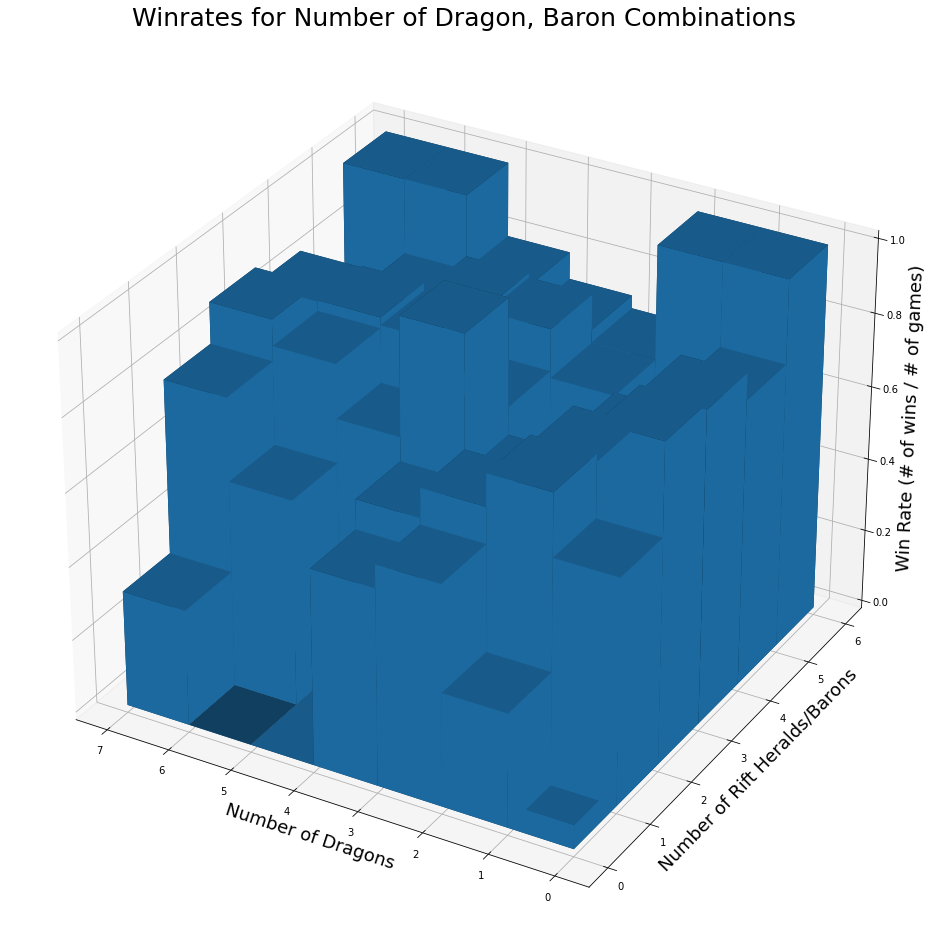

In [17]:
# setup the figure and axes
fig = plt.figure(figsize=(36, 18))
ax1 = fig.add_subplot(121, projection='3d')

_x = np.arange(7)
_y = np.arange(6)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel() # create x,y values that will make a grid in the bar3d parameters

top = data_matrix.flatten()
bottom = np.zeros_like(top)
width = depth = 1

ax1.set_xlabel("Number of Dragons",fontsize=18)
ax1.set_ylabel("Number of Rift Heralds/Barons",fontsize=18)
ax1.set_zlabel("Win Rate (# of wins / # of games)",fontsize=18)
ax1.bar3d(x, y, bottom, width, depth, top, shade=True)
ax1.set_title('Winrates for Number of Dragon, Baron Combinations', fontsize=25)
ax1.invert_xaxis() # we want 0 dragons, 0 barons to be in the front corner of the isometric view

plt.show()

### Viewing Team Composition
We will use the *JSON* library again to convert the numerical identifier for champions into the "class" of each champion, which can be one or any combination of the following: Mage, Tank, Support, Marksman, Assassin, and Fighter. These classes were decided by the Riot Developers, and exist to place the champions into archetypes.

In [18]:
champion_info2 = {}; # this will be a dictionary mapping champion ID to a set of parameters

with open("/home/jovyan/notebooks/Data/champion_info_2.json", "r") as read_file:
    champion_info2 = json.load(read_file)
    champion_info2 = champion_info2['data'] # we don't need the game version and other extraneous data

def champ_id_map_tags(id): # this function will serve as a map
    return champion_info2[champion_info[id]['key']]['tags']

# the dataset gives numerical id's, while all json keys are arrays of classes
games['t1_champ1_tags'] = games['t1_champ1id'].astype(str)
games['t1_champ1_tags'] = games['t1_champ1_tags'].map(champ_id_map_tags) # apply id string -> classes mapping function
display(games[['t1_champ1id', 't1_champ1_tags']].head(6))

,t1_champ1id,t1_champ1_tags
0,8,"[Mage, Tank]"
1,119,[Marksman]
2,18,"[Marksman, Assassin]"
3,57,"[Tank, Mage]"
4,19,"[Fighter, Tank]"
5,40,"[Support, Mage]"


Let's add a new column for the games DataFrame that shows the champion archetype for each player.

In [19]:
# the dataset gives numerical id's, while all json tags are arrays of classes
games['t1_champ2_tags'] = games['t1_champ2id'].astype(str)
games['t1_champ2_tags'] = games['t1_champ2_tags'].map(champ_id_map_tags) # apply id string -> classes mapping function
games['t1_champ3_tags'] = games['t1_champ3id'].astype(str)
games['t1_champ3_tags'] = games['t1_champ3_tags'].map(champ_id_map_tags) # apply id string -> classes mapping function
games['t1_champ4_tags'] = games['t1_champ4id'].astype(str)
games['t1_champ4_tags'] = games['t1_champ4_tags'].map(champ_id_map_tags) # apply id string -> classes mapping function
games['t1_champ5_tags'] = games['t1_champ5id'].astype(str)
games['t1_champ5_tags'] = games['t1_champ5_tags'].map(champ_id_map_tags) # apply id string -> classes mapping function
games['t2_champ1_tags'] = games['t2_champ1id'].astype(str)
games['t2_champ1_tags'] = games['t2_champ1_tags'].map(champ_id_map_tags) # apply id string -> classes mapping function
games['t2_champ2_tags'] = games['t2_champ2id'].astype(str)
games['t2_champ2_tags'] = games['t2_champ2_tags'].map(champ_id_map_tags) # apply id string -> classes mapping function
games['t2_champ3_tags'] = games['t2_champ3id'].astype(str)
games['t2_champ3_tags'] = games['t2_champ3_tags'].map(champ_id_map_tags) # apply id string -> classes mapping function
games['t2_champ4_tags'] = games['t2_champ4id'].astype(str)
games['t2_champ4_tags'] = games['t2_champ4_tags'].map(champ_id_map_tags) # apply id string -> classes mapping function
games['t2_champ5_tags'] = games['t2_champ5id'].astype(str)
games['t2_champ5_tags'] = games['t2_champ5_tags'].map(champ_id_map_tags) # apply id string -> classes mapping function

games_classes = games.filter(['t1_champ1_tags','t1_champ2_tags','t1_champ3_tags','t1_champ4_tags','t1_champ5_tags',
                    't2_champ1_tags','t2_champ2_tags','t2_champ3_tags','t2_champ4_tags','t2_champ5_tags'], axis=1)
display(games_classes)

,t1_champ1_tags,t1_champ2_tags,t1_champ3_tags,t1_champ4_tags,t1_champ5_tags,t2_champ1_tags,t2_champ2_tags,t2_champ3_tags,t2_champ4_tags,t2_champ5_tags
0,"[Mage, Tank]","[Support, Mage]","[Marksman, Mage]","[Assassin, Fighter]",[Mage],[Marksman],[Marksman],"[Fighter, Tank]","[Assassin, Fighter]","[Support, Fighter]"
1,[Marksman],"[Fighter, Assassin]","[Assassin, Fighter]","[Fighter, Support]",[Assassin],"[Tank, Fighter]","[Mage, Support]","[Fighter, Tank]","[Fighter, Assassin]","[Fighter, Assassin]"
2,"[Marksman, Assassin]","[Fighter, Assassin]","[Support, Mage]","[Fighter, Mage]","[Assassin, Mage]",[Mage],"[Support, Fighter]","[Fighter, Marksman]","[Fighter, Assassin]","[Marksman, Support]"
3,"[Tank, Mage]",[Mage],"[Marksman, Assassin]","[Mage, Support]","[Fighter, Tank]","[Mage, Assassin]","[Fighter, Tank]","[Support, Fighter]","[Fighter, Assassin]","[Marksman, Support]"
4,"[Fighter, Tank]","[Marksman, Assassin]","[Support, Mage]",[Marksman],"[Mage, Support]","[Support, Mage]","[Tank, Fighter]","[Fighter, Assassin]","[Assassin, Mage]",[Marksman]
...,...,...,...,...,...,...,...,...,...,...
50281,"[Fighter, Tank]",[Marksman],"[Assassin, Fighter]","[Support, Mage]","[Fighter, Assassin]",[Mage],"[Fighter, Tank]","[Marksman, Assassin]","[Support, Mage]","[Fighter, Mage]"
50282,"[Mage, Assassin]","[Tank, Mage]","[Tank, Mage]","[Support, Fighter]","[Marksman, Assassin]","[Fighter, Tank]",[Marksman],"[Tank, Support]","[Fighter, Tank]",[Mage]
50283,"[Fighter, Assassin]","[Marksman, Assassin]","[Support, Mage]","[Marksman, Mage]","[Fighter, Mage]",[Mage],[Marksman],"[Tank, Fighter]","[Mage, Support]","[Mage, Support]"
50284,"[Assassin, Fighter]",[Marksman],"[Fighter, Tank]","[Support, Tank]","[Mage, Support]",[Marksman],"[Assassin, Fighter]","[Mage, Support]",[Mage],"[Assassin, Fighter]"


Now that we have converted all champion identifiers into the classes of the champion, we will keep track of the number of champions of each class. After totalling the number of each class of champions, we will be able to calculate the average occurrences of each class in each team. 

In [20]:
import numpy as np

classes_count = {} # this dictionary will be a dictionary mapping the amount of champions to each class the champion falls under

# this for loop will iterate through each game
for i, game in games_classes.iterrows():
    # this for loop will iterate through each column (should be only the classes of two teams' champions)
    for champion in game:
        # this for loop will iterate through each class of each champion
        for champion_class in champion:
            if champion_class in classes_count:
                classes_count[champion_class] += 1
            else:
                classes_count[champion_class] = 1

class_avgs = {} # this dictionary will be a dictionary mapping the average amount of each class in each team
for champion_class, class_sum in classes_count.items():
    class_avg = class_sum/(2 * (len(games_classes))) # two teams for each game
    class_avgs[champion_class] = class_avg
    print(champion_class, ': ', class_avg)

Mage :  1.6686254623553276
Tank :  1.1500417611263571
Support :  1.1608101658513303
Marksman :  1.2258083760887721
Assassin :  1.591108857336038
Fighter :  2.194368213816967


Below is a visual display of the average team composition in a LoL game. Note that characters can exist in multiple archetypes, so the average numbers won't necessarily add up to 5.

This data is interpreted as follows: if "Mage" has a value of 1.668, then a team has 1.668 occurrences of mage characters on average.

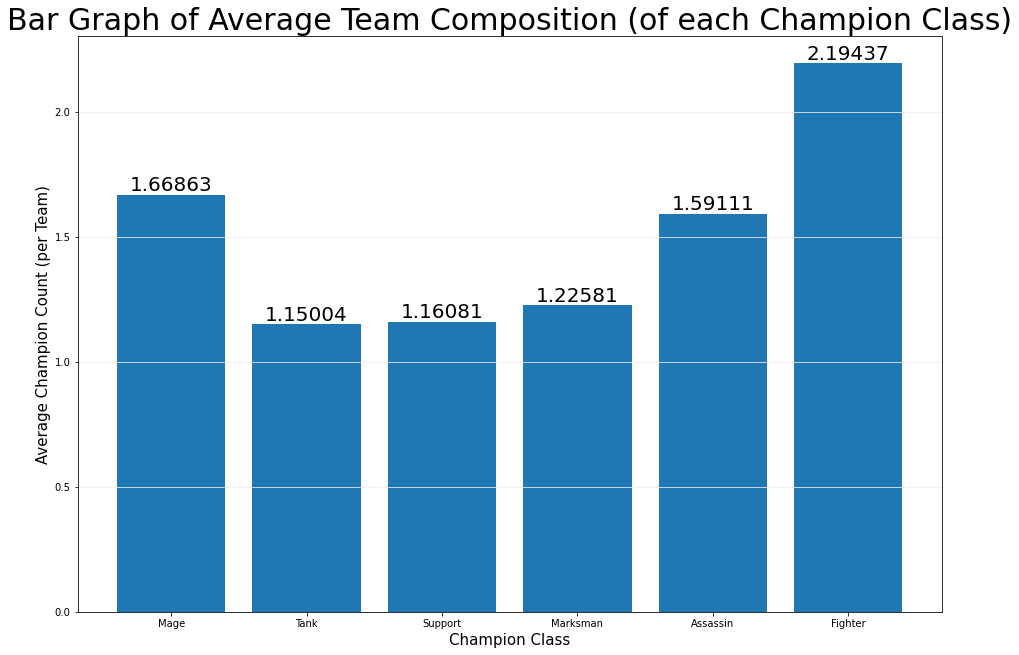

In [21]:
import matplotlib.pyplot as plt
team_comp_fig = plt.figure()
ax = team_comp_fig.add_axes([0,0,1,1])
champion_class = class_avgs.keys()
class_avg = class_avgs.values()
bars = ax.bar(champion_class,class_avg)

# configurations for the bar graph
ax.bar_label(bars, fontsize= 20)
plt.title("Bar Graph of Average Team Composition (of each Champion Class)", fontsize=30)
plt.xlabel('Champion Class', fontsize=15)
plt.ylabel('Average Champion Count (per Team)', fontsize=15)
# plt.legend(title='TeamIDs',title_fontsize=15,loc='center left', bbox_to_anchor=(1.01, 0.5))
team_comp_fig.set_figwidth(12)
team_comp_fig.set_figheight(8)
ax.yaxis.grid(True, color='#EEEEEE')
plt.show()

### Analysis of "Scaling" Champions

A champion in LoL is known as a "scaling" champion if their winrate increases with game length. There are also champions that are better at the beginning of games, but their effectiveness falls off over time. The only way to demonstrate/visualize this phenomenon is to graph a champion's winrate over time.

Since a single instance of whether or not a champion wins in a game of a particular length is a categorical variable (0 = loss, 1 = win), we instead need to count the number of wins and losses across a specific interval (which is way more useful!).

The minimum game time should be ~15 minutes. Let's split the game times into the following 5 minute intervals after 15 minutes: {15-20, 20-25, 25-30, 30-35, 35-40}. Checking the winrate of a specific champion at a given interval should be relatively straightforward as well:

In [22]:
def get_champ_wr_at_interval(championID, time_min, time_max):
    win = 0
    loss = 0
    for index, row in games.iterrows():
        if row['gameDuration'] >= time_min and row['gameDuration'] < time_max:
            if championID in team1_champs.loc[index].values:
                if row['winner'] == 1:
                    win += 1
                else:
                    loss += 1
            elif championID in team2_champs.loc[index].values:
                if row['winner'] == 2:
                    win += 1
                else:
                    loss += 1
                    
    return (win / (win + loss))
                    
# we can quickly test Annie's winrate at different intervals (championID = 1)
display(get_champ_wr_at_interval(1, 900, 1200))
display(get_champ_wr_at_interval(1, 2100, 2400))

0.3795180722891566

0.5229357798165137

This function is effective for looking at one specific interval, but we will need to make some changes in order to check large numbers of intervals at once. We should *not* call this function over many different intervals, because the function loops over the entire dataframe looking for rows that meet the criteria.

It is much more efficient to do a single pass over the dataset with the necessary intervals in mind. An example of doing this is demonstrated below:

In [23]:
# times will be an array of 2-element arrays in the form [ [min, max] [min, max] ]
# we will give the last element [3300, 99999] to show 35+ minutes
def get_champ_wr_over_interval(championID, times, interval):
    data = {} # dict that contains the winrate information
    for x in times:
        data[x] = {}
        data[x]['w'] = 0 # data[x] represents a starting time
        # data[x]['w'] contains the number of wins in the time interval (x, x+interval)
        data[x]['l'] = 0
    for index, row in games.iterrows():
        if championID in team1_champs.loc[index].values:
            if row['winner'] == 1:
                for x in times:
                    if row['gameDuration'] >= x and row['gameDuration'] < x + interval:
                        data[x]['w'] += 1
                        break # if the champion wins in this interval, they cannot also win in another interval
                        # this saves time and CPU cycles
            else:
                for x in times:
                    if row['gameDuration'] >= x and row['gameDuration'] < x + interval:
                        data[x]['l'] += 1
                        break
        elif championID in team2_champs.loc[index].values:
            if row['winner'] == 2:
                for x in times:
                    if row['gameDuration'] >= x and row['gameDuration'] < x + interval:
                        data[x]['w'] += 1
                        break
            else:
                for x in times:
                    if row['gameDuration'] >= x and row['gameDuration'] < x + interval:
                        data[x]['l'] += 1
                        break
                        
    winrates = [] # flattening the win and loss data into a simple winrate number is much more readable
    for x in times:
        # game numbers lower than 20 are likely to produce results with high variances, so we should ignore them for now
        if data[x]['l'] > 0 and data[x]['w'] + data[x]['l'] > 20:
            winrate = data[x]['w'] / (data[x]['w'] + data[x]['l'])
            winrates.append(winrate)
        else:
            winrates.append(None)
                    
    return winrates

intervals = [900, 1200, 1500, 1800, 2100, 2400, 2700, 3000, 3300, 3500]
display(get_champ_wr_over_interval(10, intervals, 300))

[0.4807692307692308,
 0.4491525423728814,
 0.5145631067961165,
 0.5249500998003992,
 0.5472972972972973,
 0.4434782608695652,
 0.6136363636363636,
 None,
 None,
 None]

This winrate data would be much more interpretable on a graph since we are hoping to look for change over time. Noticing change over time is perfectly exemplified with a line graph, which can be generated again using *pyplot* as below:

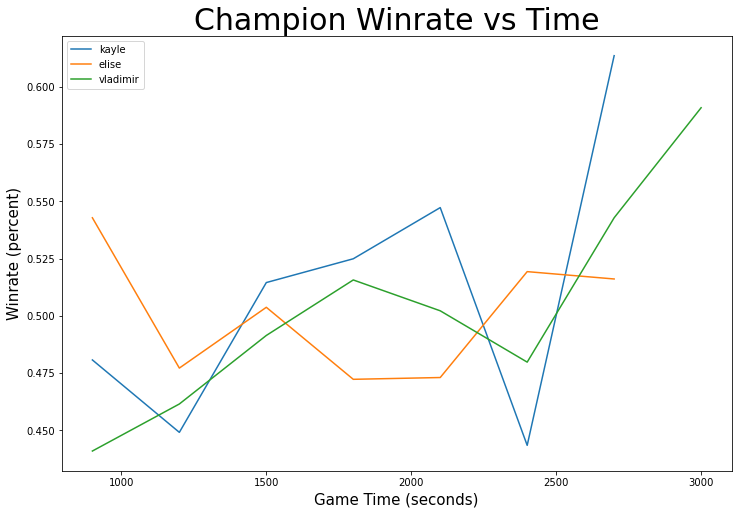

In [24]:
import matplotlib.pyplot as plt

kayle_data = get_champ_wr_over_interval(10, intervals, 300)
elise_data = get_champ_wr_over_interval(60, intervals, 300)
vladimir_data = get_champ_wr_over_interval(8, intervals, 300)

winrate_fig = plt.figure()
plt.plot(intervals, kayle_data, label = "kayle")
plt.plot(intervals, elise_data, label = "elise")
plt.plot(intervals, vladimir_data, label = "vladimir")

plt.title("Champion Winrate vs Time", fontsize=30)
plt.xlabel('Game Time (seconds)', fontsize=15)
plt.ylabel('Winrate (percent)', fontsize=15)
winrate_fig.set_figwidth(12)
winrate_fig.set_figheight(8)
plt.legend(loc="upper left")
plt.show()

Vladimir's data looks fairly promising as a candidate for being a "scaling champion". Let's figure out exactly how well he scales over time, and see if the results are statistically significant.

We will do this using the *scipy.stats* library--specifically *linregress*. This will perform a linear regression on our data and calculate the p-value of the results.

In this case, the null hypothesis is that the real slope is actually 0, and there is no correlation between the X and Y axes. Let's run the data through the library and see the output:

In [25]:
from scipy.stats import linregress

vladimir_data = get_champ_wr_over_interval(8, intervals, 300)
# the data needs to be cleaned slightly, since passing in None or np.NaN to linregress will cause a fatal error
# we will simply exclude time intervals that do not have an available winrate from the regression
x = []
y = []
for i in range(0,len(intervals)):
    if not vladimir_data[i] is None: # here we exclude any None winrates
        x.append(intervals[i])
        y.append(vladimir_data[i])

regression = linregress(x, y)
display(regression)

LinregressResult(slope=5.5857294463845266e-05, intercept=0.394267669859294, rvalue=0.8663719590107154, pvalue=0.005383435845146411, stderr=1.314461240838731e-05, intercept_stderr=0.02717789673968111)

Displayed is the LinregressResult object with all its parameters. This isn't a super readable format, so let's change the scale and separate out the important values:

In [26]:
slope = regression.slope
intercept = regression.intercept
pvalue = regression.pvalue

display("Vladimir's winrate increases {}% for every second of gameplay".format(100* slope))
display("Vladimir's winrate increases {}% for every minute of gameplay".format(100 * slope * 60))
display("Vladimir's winrate increases {}% for every 5 minutes of gameplay".format(100 * slope * 300))
display("The likelihood of this line result occurring naturally is {}".format(pvalue))

"Vladimir's winrate increases 0.005585729446384527% for every second of gameplay"

"Vladimir's winrate increases 0.3351437667830716% for every minute of gameplay"

"Vladimir's winrate increases 1.6757188339153581% for every 5 minutes of gameplay"

'The likelihood of this line result occurring naturally is 0.005383435845146411'

As in our other tests, a p value below 0.05 is sufficient to reject the null hypothesis. Thus, Vladimir is certainly a champion whose winrate correlates positively with time! Plotting the regression line is easy after acquiring the numbers from the regression:

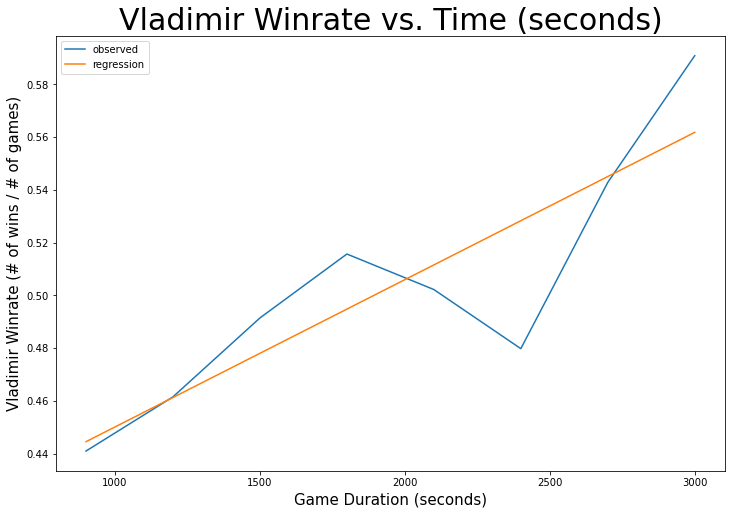

In [27]:
y2 = (np.asarray(x) * regression.slope) + regression.intercept

winrate_fig2 = plt.figure()
plt.plot(x, y, label="observed")
plt.plot(x, y2, label="regression")

plt.title('Vladimir Winrate vs. Time (seconds)', fontsize=30)
plt.xlabel('Game Duration (seconds)', fontsize=15)
plt.ylabel('Vladimir Winrate (# of wins / # of games)', fontsize=15)
plt.legend(loc="upper left")
winrate_fig2.set_figwidth(12)
winrate_fig2.set_figheight(8)
plt.show()

## Conclusion and Good Practices

Many useful insights can be drawn from the LoL match dataset explored above. Depending on your access level, even more detailed data can be acquired through the Riot Developer Portal. Websites such as u.gg and op.gg go into great depths using similar data analysis techniques across millions of matches.

Some interesting conclusions/results we derived from the dataset:

1. Noted the effects of "first blood" on the winrate of a given team (and suggested some potential reasoning)
2. Analyzed the characters that gave their teams the highest chance of winning (with statistical significance testing)
3. Calculated and displayed win percentages for combinations of secondary objectives
4. Calculated the number of characters of each archetype that appear in the average LoL team
5. Analyzed the concept of "scaling" champions and performed a linear regression to show the relationship between their winrate and time

The examples done in this tutorial should be a good starting point for most curious LoL players to look for relationships and patterns in the game data. Here are some tips for analyzing LoL datasets in the future:

1. When maintaining a dataset that analyzes winrates, always store the number of wins and losses rather than the winrate. Calculating and saving only the winrate percentage value is destructive--a new value cannot be added into the average post-calculation
2. Always think about conflating variables. For example--the fairness of the match is likely a conflating variable with the first blood vs. win rate analysis
3. Avoid excessively looping over DataFrames if possible. In many of our examples, we had to rewrite functions to do a calculation in a single pass
4. Choose the correct statistical test and make sure the p-value is significant!

## Resources

[1] https://www.kaggle.com/datasets/datasnaek/league-of-legends?resource=download  
[2] https://pandas.pydata.org/docs/  
[3] https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html  
[4] https://mobalytics.gg/infographics/best-champions-season-9-meta-recap/  
[5] https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.html\  
[6] https://www.geeksforgeeks.org/python-flatten-a-2d-numpy-array-into-1d-array/  
[7] https://matplotlib.org/stable/gallery/mplot3d/3d_bars.html  